In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !gdown --id 1PwV2G9nrQ9AA5uWqMj2s9ZUeWQVuVEaf
# !gdown --id 1--bWJ07UHXnO0F-DMiKBgh7zg-sysBe-

In [ ]:
# !wget --keep-session-cookies --save-cookies=cookies.txt --post-data 'username=myusername&password=mypassword&submit=Login' https://www.cityscapes-dataset.com/login/
# !wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=1
# !wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=3

In [2]:
%%bash

unzip /content/drive/MyDrive/CS_project/CS406/Cityscapes_dataset/gtFine_trainvaltest.zip > cc.txt
rm -f cc.txt
rm -f README
rm -f license.txt

unzip /content/drive/MyDrive/CS_project/CS406/Cityscapes_dataset/leftImg8bit_trainvaltest.zip > cc.txt
rm -f cc.txt
rm -f README
rm -f license.txt

# Requirements

In [3]:
import os
from os import path
# os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import random
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.layers import  Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout, Reshape, Permute
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
import tqdm as tqdm
import cv2
import cv2 as cv
import time
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from moviepy.editor import VideoFileClip, ImageSequenceClip

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2351104/45929032 bytes (5.1%)5947392/45929032 bytes (12.9%)9592832/45929032 bytes (20.9%)13156352/45929032 bytes (28.6%)16793600/45929032 bytes (36.6%)20332544/45929032 bytes (44.3%)23445504/45929032 bytes (51.0%)27033600/45929032 bytes (58.9%)30638080/45929032 bytes (66.7%)34316288/45929032 bytes (74.7%)37814272/45929032 bytes (82.3%)41426944/45929032 bytes (90.2%)

# Losses

In [ ]:
def dice_coeff(y_true, y_pred):
  smooth = 1.
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  dice_score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
  return dice_score

def IoU_coeff(y_true, y_pred):
  smooth = 1.
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  iou_score = (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)
  return iou_score

def dice_loss(y_true, y_pred):
  loss = 1 - dice_coeff(y_true, y_pred)
  return loss

def total_loss(y_true, y_pred):
  loss = categorical_crossentropy(y_true, y_pred) + (3*dice_loss(y_true, y_pred))
  return loss

# Define U-Net model

In [ ]:
def unet(num_classes, input_shape, lr_init, vgg_weight_path=None):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    block_4_out = Activation('relu')(x)

    x = MaxPooling2D()(block_4_out)

    # Block 5
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    for_pretrained_weight = MaxPooling2D()(x)

    # Load pretrained weights.
    if vgg_weight_path is not None:
        vgg16 = Model(img_input, for_pretrained_weight)
        vgg16.load_weights(vgg_weight_path, by_name=True)

    # UP 1
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_4_out])
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # last conv
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(lr=lr_init),
                  loss= [total_loss], metrics=[dice_coeff, IoU_coeff, 'accuracy'])
    return model

# Data

In [ ]:
# img_height, img_width = 256, 512
# cats = {'void': [0, 1, 2, 3, 4, 5, 6],
#  'flat': [7, 8, 9, 10],
#  'construction': [11, 12, 13, 14, 15, 16],
#  'object': [17, 18, 19, 20],
#  'nature': [21, 22],
#  'sky': [23],
#  'human': [24, 25],
#  'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]}

In [5]:
# Use only 3 classes.
labels = ['background', 'person', 'car', 'road']

In [6]:
from keras.preprocessing.image import ImageDataGenerator
def pre_processing(img):
    # Random exposure and saturation (0.9 ~ 1.1 scale)
    rand_s = random.uniform(0.9, 1.1)
    rand_v = random.uniform(0.9, 1.1)

    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    tmp = np.ones_like(img[:, :, 1]) * 255
    img[:, :, 1] = np.where(img[:, :, 1] * rand_s > 255, tmp, img[:, :, 1] * rand_s)
    img[:, :, 2] = np.where(img[:, :, 2] * rand_v > 255, tmp, img[:, :, 2] * rand_v)

    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)

    # Centering helps normalization image (-1 ~ 1 value)
    return img / 127.5 - 1

def get_data_gen_args(mode):
    if mode == 'train' or mode == 'val':
        x_data_gen_args = dict(preprocessing_function=pre_processing,
                               shear_range=0.1,
                               zoom_range=0.1,
                               rotation_range=10,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               fill_mode='constant',
                               horizontal_flip=True)

        y_data_gen_args = dict(shear_range=0.1,
                               zoom_range=0.1,
                               rotation_range=10,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               fill_mode='constant',
                               horizontal_flip=True)

    elif mode == 'test':
        x_data_gen_args = dict(preprocessing_function=pre_processing)
        y_data_gen_args = dict()

    else:
        print("Data_generator function should get mode arg 'train' or 'val' or 'test'.")
        return -1

    return x_data_gen_args, y_data_gen_args

# One hot encoding for y_img.
def get_result_map(b_size, y_img):
    y_img = np.squeeze(y_img, axis=3)
    result_map = np.zeros((b_size, 256, 512, 4))

    # For np.where calculation.
    person = (y_img == 24)
    person1 = (y_img == 25)
    person = np.logical_or(person, person1)

    car = (y_img == 26)
    car1 = (y_img == 27)
    car2 = (y_img == 28)
    car3 = (y_img == 29)
    car4 = (y_img == 30)
    car5 = (y_img == 31)
    car6 = (y_img == 32)
    car7 = (y_img == 33)
    car8 = (y_img == -1)
    
    car = np.logical_or(car , car1)
    car = np.logical_or(car , car2)
    car = np.logical_or(car , car3)
    car = np.logical_or(car , car4)
    car = np.logical_or(car , car5)
    car = np.logical_or(car , car6)
    car = np.logical_or(car , car7)
    car = np.logical_or(car , car8)

    road = (y_img == 7)

    background = np.logical_not(person + car + road)

    result_map[:, :, :, 0] = np.where(background, 1, 0)
    result_map[:, :, :, 1] = np.where(person, 1, 0)
    result_map[:, :, :, 2] = np.where(car, 1, 0)
    result_map[:, :, :, 3] = np.where(road, 1, 0)

    return result_map

# Data generator for fit_generator.
def data_generator(dataset, b_size, mode):

    x_imgs = dataset[0]
    y_imgs = dataset[1]

    # Make ImageDataGenerator.
    x_data_gen_args, y_data_gen_args = get_data_gen_args(mode)
    x_data_gen = ImageDataGenerator(**x_data_gen_args)
    y_data_gen = ImageDataGenerator(**y_data_gen_args)

    # random index for random data access.
    d_size = x_imgs.shape[0]
    shuffled_idx = list(range(d_size))

    x = []
    y = []
    while True:
        random.shuffle(shuffled_idx)
        for i in range(d_size):
            idx = shuffled_idx[i]

            x.append(x_imgs[idx].reshape((256, 512, 3)))
            y.append(y_imgs[idx].reshape((256, 512, 1)))

            if len(x) == b_size:
                # Adapt ImageDataGenerator flow method for data augmentation.
                _ = np.zeros(b_size)
                seed = random.randrange(1, 1000)

                x_tmp_gen = x_data_gen.flow(np.array(x), _,
                                            batch_size=b_size,
                                            seed=seed)
                y_tmp_gen = y_data_gen.flow(np.array(y), _,
                                            batch_size=b_size,
                                            seed=seed)

                # Finally, yield x, y data.
                x_result, _ = next(x_tmp_gen)
                y_result, _ = next(y_tmp_gen)

                yield x_result, get_result_map(b_size, y_result)

                x.clear()
                y.clear()

def load_data(lst_path_x, lst_path_y):
    images = []
    labels = []
    # i = 0
    # l = len(lst_path_x)
    for x,y in tqdm.tqdm(zip(lst_path_x, lst_path_y)):
        images.append(cv2.cvtColor(cv.resize(cv.imread(x),(512,256)), cv2.COLOR_BGR2RGB))

        y_img = cv.resize(cv.imread(y),(512,256))
        y_img = y_img[:, :, 0]
        labels.append(y_img)
        
    return np.asarray(images),np.asarray(labels)

# Train

In [7]:
!nvidia-smi

Wed Jan  5 02:31:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load dataset Cityscapes

In [ ]:
# /content/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png
# /content/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_labelIds.png

In [10]:
lst_image_train_path = []
lst_mask_train_path = []

lst_image_val_path = []
lst_mask_val_path = []

lst_image_test_path = []
lst_mask_test_path = []

for f in os.listdir("/content/leftImg8bit/train/"):
  lst_image_train_path.append("/content/leftImg8bit/train/"+f+"/")
for f in os.listdir("/content/gtFine/train/"):
  lst_mask_train_path.append("/content/gtFine/train/"+f+"/") 

for f in os.listdir("/content/leftImg8bit/val/"):
  lst_image_val_path.append("/content/leftImg8bit/val/"+f+"/") 
for f in os.listdir("/content/gtFine/val/"):
  lst_mask_val_path.append("/content/gtFine/val/"+f+"/") 
  
for f in os.listdir("/content/leftImg8bit/test/"):
  lst_image_test_path.append("/content/leftImg8bit/test/"+f+"/") 
for f in os.listdir("/content/gtFine/test/"):
  lst_mask_test_path.append("/content/gtFine/test/"+f+"/")

lst_image_train_path = sorted(lst_image_train_path)
lst_mask_train_path = sorted(lst_mask_train_path)

lst_image_val_path = sorted(lst_image_val_path)
lst_mask_val_path = sorted(lst_mask_val_path)

lst_image_test_path = sorted(lst_image_test_path)
lst_mask_test_path = sorted(lst_mask_test_path)

### Train

In [ ]:
# Train
lst_train_x = []
lst_train_y = []

# load image path
for folder in lst_image_train_path:
  for img in os.listdir(folder):
    if os.path.isfile(folder+img):
      lst_train_x.append(folder+img)
# load mask path
for folder in lst_mask_train_path:
  for mask in os.listdir(folder):
    if os.path.isfile(folder+mask) and "_gtFine_labelIds.png" in mask:
      lst_train_y.append(folder+mask)

lst_train_x = sorted(lst_train_x)
lst_train_y = sorted(lst_train_y)

print(len(lst_train_x), len(lst_train_y))

2975 2975


In [ ]:
train_dataset = load_data(lst_train_x, lst_train_y)

2975it [04:03, 12.20it/s]


### Validation

In [11]:
# Validation
lst_val_x = []
lst_val_y = []

# load image path
for folder in lst_image_val_path:
  for img in os.listdir(folder):
    if os.path.isfile(folder+img):
      lst_val_x.append(folder+img)
# load mask path
for folder in lst_mask_val_path:
  for mask in os.listdir(folder):
    if os.path.isfile(folder+mask) and "_gtFine_labelIds.png" in mask:
      lst_val_y.append(folder+mask)

lst_val_x = sorted(lst_val_x)
lst_val_y = sorted(lst_val_y)

print(len(lst_val_x), len(lst_val_y))

500 500


In [12]:
val_dataset = load_data(lst_val_x, lst_val_y)

500it [00:39, 12.69it/s]


### Test

In [13]:
# Test
lst_test_x = []
lst_test_y = []

# load image path
for folder in lst_image_test_path:
  for img in os.listdir(folder):
    if os.path.isfile(folder+img):
      lst_test_x.append(folder+img)
# load mask path
for folder in lst_mask_test_path:
  for mask in os.listdir(folder):
    if os.path.isfile(folder+mask) and "_gtFine_labelIds.png" in mask:
      lst_test_y.append(folder+mask)

lst_test_x = sorted(lst_test_x)
lst_test_y = sorted(lst_test_y)

print(len(lst_test_x), len(lst_test_y))

1525 1525


In [14]:
test_dataset = load_data(lst_test_x, lst_test_y)

1525it [01:55, 13.16it/s]


## Visual example of dataset

<Figure size 720x720 with 0 Axes>

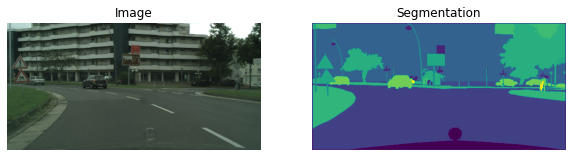

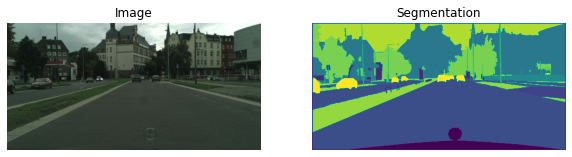

In [ ]:
import matplotlib.pyplot as plt

idx = 0
plt.figure(figsize=(10, 10))
for images, lables in zip(train_dataset[0],  train_dataset[1]):
    fig, arr = plt.subplots(1, 2 , figsize=(10, 10))
    arr[0].imshow(images)
    arr[0].set_title('Image')
    arr[0].axis("off")
    arr[1].imshow(lables)
    arr[1].set_title('Segmentation')
    arr[1].axis("off") 
    idx +=1
    if idx ==2:
      break

## Load pretrained model VGG16 offered by keras.

In [ ]:
!gdown --id 152DjgAX7OzUYl1vnd94ofwOOxjpTg6-1

Downloading...
From: https://drive.google.com/uc?id=152DjgAX7OzUYl1vnd94ofwOOxjpTg6-1
To: /content/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
100% 58.9M/58.9M [00:00<00:00, 104MB/s] 


## Initialize parameter and callback

In [15]:
batch_size = 10 # Batch size for train.
val_batch = 10 # Batch size for validation.
lr_init = 1e-4 # Initial learning rate.
# lr_decay = 5e-4 # How much to decay the learning rate.
vgg_path = "/content/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5" # Pretrained vgg16 weight path.

# val_dice_coeff, val_IoU_coeff
callback = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=1e-1, patience=2, verbose=1, min_lr = 2e-6)
model_checkpoint = ModelCheckpoint('Cityscapes-unet-semantic-model.h5', monitor='val_loss',verbose=1, save_best_only=True)

In [16]:
# Use only 3 classes.
labels = ['background', 'person', 'car', 'road']

## Initialize model Unet with VGG 16 pretrained

In [ ]:
tf.keras.backend.clear_session()
model = unet(input_shape=(256, 512, 3), 
             num_classes=len(labels),
             lr_init=lr_init, 
             vgg_weight_path=vgg_path)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 512, 64  256        ['block1_conv1[0][0]']           
 alization)                     )                                                           

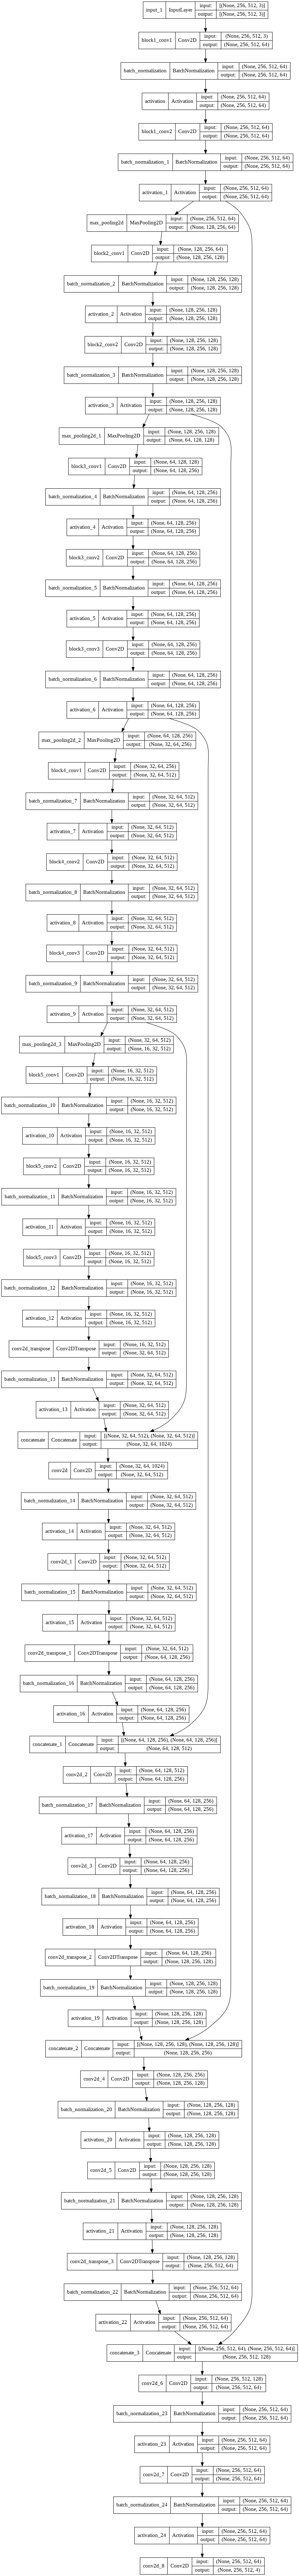

In [ ]:
tf.keras.utils.plot_model(model, show_shapes= True)

## Model training

In [ ]:
history = model.fit_generator(data_generator(train_dataset, batch_size, 'train'),
                              steps_per_epoch=len(train_dataset[0]) // batch_size,
                              validation_data=data_generator(val_dataset, val_batch, 'val'),
                              validation_steps=len(val_dataset[0]) // val_batch,
                              callbacks=[callback, reduce_lr, model_checkpoint],
                              epochs=100,
                              verbose=1)

Epoch 1/100
297/297 [==============================] - ETA: 0s - loss: 0.7766 - dice_coeff: 0.8519 - IoU_coeff: 0.7634 - accuracy: 0.8955
Epoch 00001: val_loss improved from inf to 0.45307, saving model to Cityscapes-unet-semantic-model.h5
297/297 [==============================] - 907s 3s/step - loss: 0.7766 - dice_coeff: 0.8519 - IoU_coeff: 0.7634 - accuracy: 0.8955 - val_loss: 0.4531 - val_dice_coeff: 0.9170 - val_IoU_coeff: 0.8471 - val_accuracy: 0.9364 - lr: 1.0000e-04
Epoch 2/100
297/297 [==============================] - ETA: 0s - loss: 0.3419 - dice_coeff: 0.9380 - IoU_coeff: 0.8836 - accuracy: 0.9500
Epoch 00002: val_loss did not improve from 0.45307
297/297 [==============================] - 876s 3s/step - loss: 0.3419 - dice_coeff: 0.9380 - IoU_coeff: 0.8836 - accuracy: 0.9500 - val_loss: 0.5536 - val_dice_coeff: 0.9144 - val_IoU_coeff: 0.8433 - val_accuracy: 0.9220 - lr: 1.0000e-04
Epoch 3/100
297/297 [==============================] - ETA: 0s - loss: 0.2856 - dice_coeff: 0

In [ ]:
model.save('/content/drive/MyDrive/CS_project/CS406/Cityscapes-unet-semantic-model.h5')

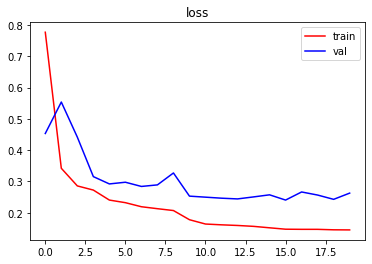

In [ ]:
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="val")
plt.legend(loc="best")
plt.savefig('Unet_loss.png')

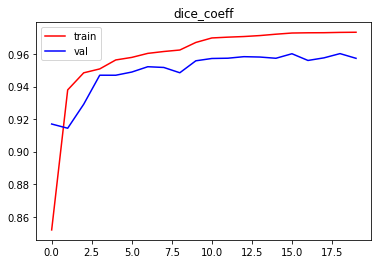

In [ ]:
plt.gcf().clear()
plt.title("dice_coeff")
plt.plot(history.history["dice_coeff"], color="r", label="train")
plt.plot(history.history["val_dice_coeff"], color="b", label="val")
plt.legend(loc="best")
plt.savefig('Unet_dice_coeff.png')

# Evaluate

## Test set

In [ ]:
highest_test = None
h_count = 0
lowest_test = None
l_count = 0

In [ ]:
#trung bình test set
result_of_test_set = model_loaded.evaluate(data_generator(test_dataset, 25, 'test'), steps = 61, callbacks=[callback, reduce_lr,model_checkpoint])

61/61 [==============================] - 141s 2s/step - loss: 4.5410 - dice_coeff: 0.5691 - IoU_coeff: 0.3980 - accuracy: 0.5688


In [ ]:
for i in tqdm.tqdm(range(len(test_dataset[0]))):
  X = np.asarray([test_dataset[0][i]])
  y= get_result_map(1, np.asarray([test_dataset[1][i].reshape((256, 512, 1))]))
  result = model_loaded.evaluate(X,y, steps = 1, callbacks=[callback, reduce_lr,model_checkpoint])
  if highest_test == None or highest_test[1:] < result[1:] and highest_test[0] >  result[0]:
    highest_test = result
    h_count = i
  if lowest_test == None or lowest_test[1:] > result[1:] and lowest_test[0] <  result[0]:
    lowest_test = result
    l_count = i

In [ ]:
#cao nhất
highest_test

[8.650247573852539, 0.656812846660614, 0.4889971911907196, 0.6579971313476562]

In [ ]:
h_count

845

In [ ]:
#thấp nhất
lowest_test

[67.68815612792969,
 0.18594738841056824,
 0.10250575095415115,
 0.18547821044921875]

In [ ]:
l_count

138

(-0.5, 511.5, 255.5, -0.5)

<Figure size 2160x2160 with 0 Axes>

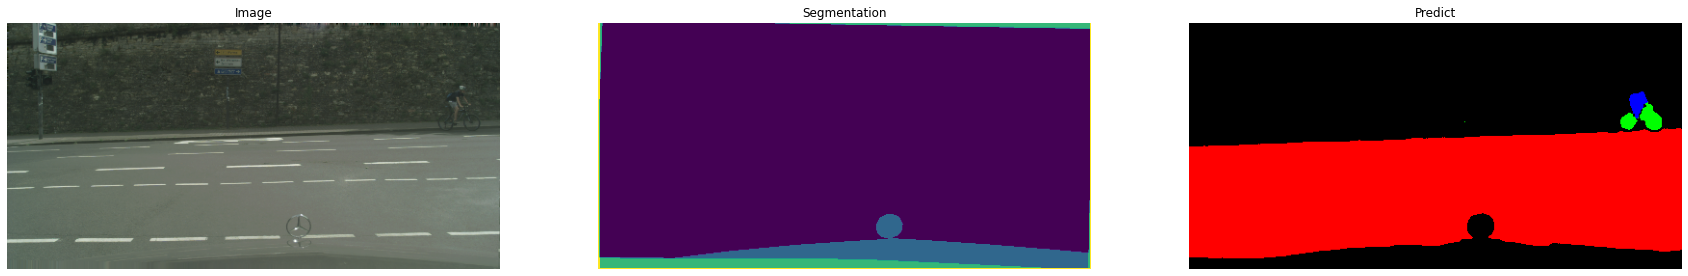

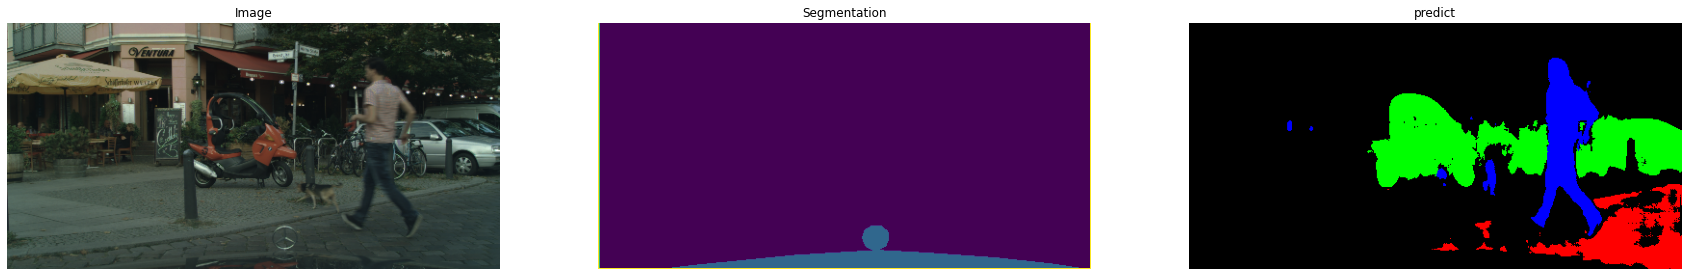

In [74]:
#visual
img_highest = cv.imread(lst_test_x[845])
x_img = cv2.cvtColor(cv.resize(img_highest, (512,256)), cv2.COLOR_BGR2RGB)
x_img = x_img / 127.5 - 1
x_img = np.expand_dims(x_img, 0)
pred = model_loaded(x_img)[0]

plt.figure(figsize=(30, 30))

fig, arr = plt.subplots(1, 3 , figsize=(30, 10))
arr[0].imshow(test_dataset[0][845])
arr[0].set_title('Image')
arr[0].axis("off")
arr[1].imshow(test_dataset[1][845])
arr[1].set_title('Segmentation')
arr[1].axis("off") 
arr[2].imshow(cv2.cvtColor(result_map_to_img(pred), cv2.COLOR_BGR2RGB))
arr[2].set_title('Predict')
arr[2].axis("off") 


img_lowest = cv.imread(lst_test_x[138])
x_img = cv2.cvtColor(cv.resize(img_lowest, (512,256)), cv2.COLOR_BGR2RGB)
x_img = x_img / 127.5 - 1
x_img = np.expand_dims(x_img, 0)
pred = model_loaded(x_img)[0]

fig, arr = plt.subplots(1, 3 , figsize=(30, 10))
arr[0].imshow(test_dataset[0][138])
arr[0].set_title('Image')
arr[0].axis("off")
arr[1].imshow(test_dataset[1][138])
arr[1].set_title('Segmentation')
arr[1].axis("off") 
arr[2].imshow(cv2.cvtColor(result_map_to_img(pred), cv2.COLOR_BGR2RGB))
arr[2].set_title('predict')
arr[2].axis("off") 

## Validation set

In [80]:
highest_val = None
h_count = 0
lowest_val = None
l_count = 0

In [ ]:
for i in tqdm.tqdm(range(len(val_dataset[0]))):
  X = np.asarray([val_dataset[0][i]])
  y= get_result_map(1, np.asarray([val_dataset[1][i].reshape((256, 512, 1))]))
  result = model_loaded.evaluate(X,y, steps = 1, callbacks=[callback, reduce_lr,model_checkpoint])
  if highest_val == None or highest_val[1:] < result[1:]:
    highest_val = result
    h_count = i
  if lowest_val == None or lowest_val[1:] > result[1:]:
    lowest_val = result
    l_count = i

In [82]:
#cao nhất
highest_val

[13.163466453552246, 0.717021107673645, 0.5588734149932861, 0.7171554565429688]

In [77]:
X = np.asarray([val_dataset[0][200]])
y= get_result_map(1, np.asarray([val_dataset[1][200].reshape((256, 512, 1))]))
result = model_loaded.evaluate(X,y, steps = 1, callbacks=[callback, reduce_lr,model_checkpoint])

1/1 [==============================] - 0s 270ms/step - loss: 58.7070 - dice_coeff: 0.3588 - IoU_coeff: 0.2186 - accuracy: 0.3586


In [83]:
h_count

286

In [84]:
#thấp nhất
lowest_val

[93.39305114746094,
 0.09665413945913315,
 0.050783075392246246,
 0.09590911865234375]

In [85]:
l_count

325

(-0.5, 511.5, 255.5, -0.5)

<Figure size 2160x2160 with 0 Axes>

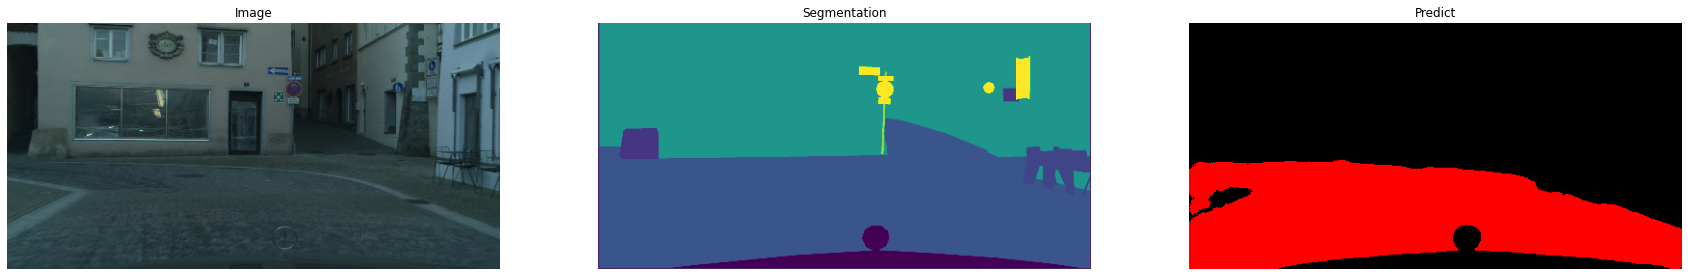

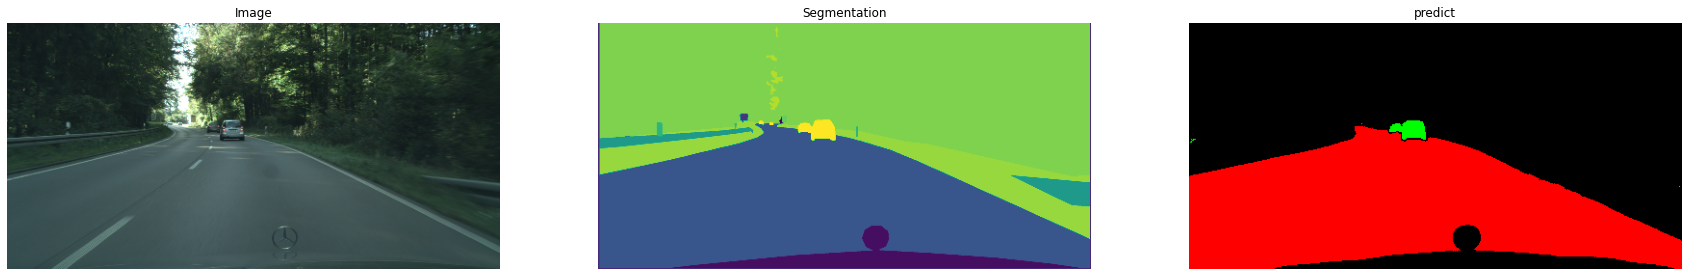

In [88]:
#visual
img_highest = cv.imread(lst_val_x[286])
x_img = cv2.cvtColor(cv.resize(img_highest, (512,256)), cv2.COLOR_BGR2RGB)
x_img = x_img / 127.5 - 1
x_img = np.expand_dims(x_img, 0)
pred = model_loaded(x_img)[0]

plt.figure(figsize=(30, 30))

fig, arr = plt.subplots(1, 3 , figsize=(30, 10))
arr[0].imshow(val_dataset[0][286])
arr[0].set_title('Image')
arr[0].axis("off")
arr[1].imshow(val_dataset[1][286])
arr[1].set_title('Segmentation')
arr[1].axis("off") 
arr[2].imshow(cv2.cvtColor(result_map_to_img(pred), cv2.COLOR_BGR2RGB))
arr[2].set_title('Predict')
arr[2].axis("off") 


img_lowest = cv.imread(lst_val_x[325])
x_img = cv2.cvtColor(cv.resize(img_lowest, (512,256)), cv2.COLOR_BGR2RGB)
x_img = x_img / 127.5 - 1
x_img = np.expand_dims(x_img, 0)
pred = model_loaded(x_img)[0]

fig, arr = plt.subplots(1, 3 , figsize=(30, 10))
arr[0].imshow(val_dataset[0][325])
arr[0].set_title('Image')
arr[0].axis("off")
arr[1].imshow(val_dataset[1][325])
arr[1].set_title('Segmentation')
arr[1].axis("off") 
arr[2].imshow(cv2.cvtColor(result_map_to_img(pred), cv2.COLOR_BGR2RGB))
arr[2].set_title('predict')
arr[2].axis("off") 

# Testing

In [19]:
model_loaded = load_model('/content/drive/MyDrive/CS_project/CS406/Cityscapes-unet-semantic-model.h5', custom_objects= {'dice_coeff':dice_coeff, 'IoU_coeff': IoU_coeff, 'total_loss':total_loss})

In [71]:
from google.colab.patches import cv2_imshow
from skimage import io
import time

def result_map_to_img(res_map):
    img = np.zeros((256, 512, 3), dtype=np.uint8)
    res_map = np.squeeze(res_map)

    argmax_idx = np.argmax(res_map, axis=2)

    # For np.where calculation.
    person = (argmax_idx == 3)
    car = (argmax_idx == 2)
    road = (argmax_idx == 1)

    img[:, :, 2] = np.where(person, 255, 0)
    img[:, :, 1] = np.where(car, 255, 0)
    img[:, :, 0] = np.where(road, 255, 0)

    return img

color_map = {
 '0': [0, 0, 0],
 '1': [255, 0, 0],
 '2': [0, 255, 0],
 '3': [0, 0, 255]
}

def pp(image,mask):
    alpha = 0.6
    dims = image.shape
    z = cv2.resize(mask, (dims[1], dims[0]))
    y = np.argmax(z, axis=2)

    img_color = image.copy()
    for i in range(dims[0]):
        for j in range(dims[1]):
            img_color[i, j] = color_map[str(y[i, j])]
    cv2.addWeighted(image, alpha, img_color, 1-alpha, 0, img_color)
    return img_color
def show_img_demo(x_img_org, url = False, show = True):
  if show:
    if url:
      cv2_imshow(cv2.cvtColor(x_img_org, cv2.COLOR_RGB2BGR))
    else:
      cv2_imshow(x_img_org)
  if url:
      x_img = cv.resize(x_img_org, (512,256))
  else:
      x_img = cv2.cvtColor(cv.resize(x_img_org, (512,256)), cv2.COLOR_BGR2RGB)
  x_img = x_img / 127.5 - 1
  x_img = np.expand_dims(x_img, 0)

  s = time.time()
  pred = model_loaded.predict(x_img)
  e = time.time()
  t = e-s
  print(f'total time taken = {t} s')
  res = result_map_to_img(pred[0])
  if show:
    cv2_imshow(res)
    
  img_in = cv2.cvtColor(x_img_org, cv2.COLOR_RGB2BGR) if url else x_img_org
  img_w_mask = pp(img_in, pred[0])
  if show:
    cv2_imshow(img_w_mask)
  return img_w_mask, t

## By image

downloading https://previews.123rf.com/images/elenaboronina/elenaboronina1703/elenaboronina170300044/73777664-cars-driving-down-city-street-st-petersburg-buildings-architecture.jpg


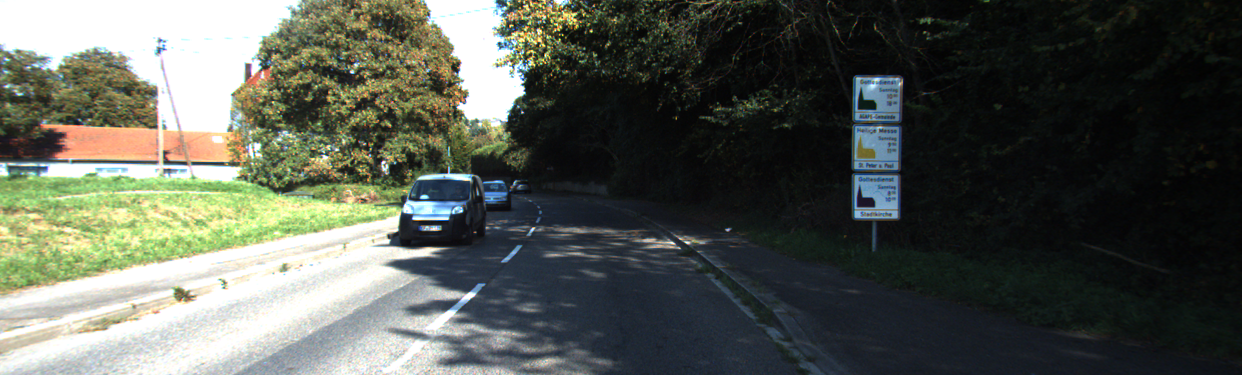

total time taken = 0.32057642936706543 s


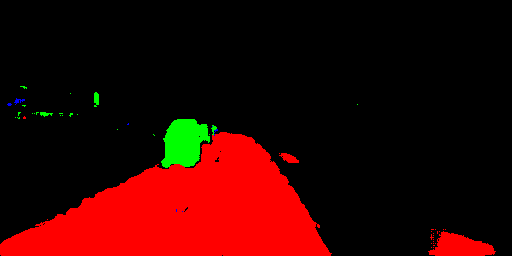

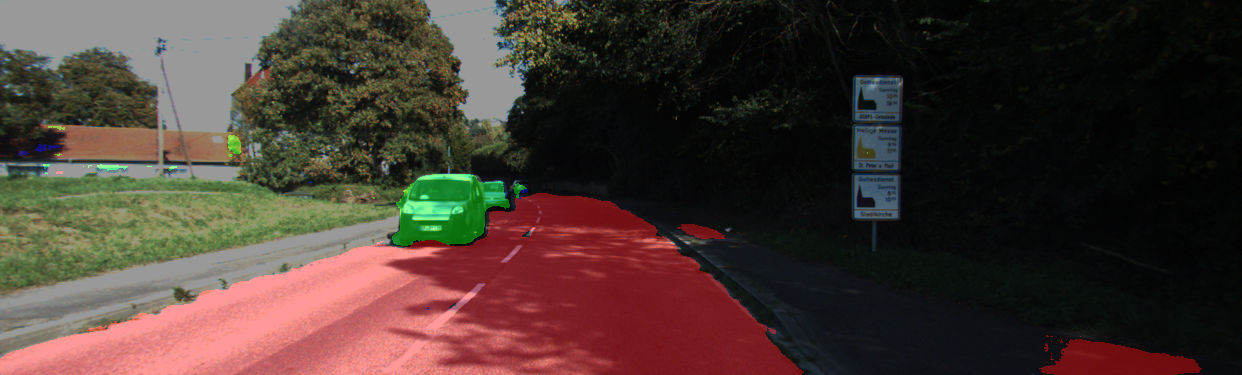

'   0 : Background : None\n      1 : road : Red\n      2 : vehicle : Green\n      3 : human : Blue\n'

In [72]:
url = "https://previews.123rf.com/images/elenaboronina/elenaboronina1703/elenaboronina170300044/73777664-cars-driving-down-city-street-st-petersburg-buildings-architecture.jpg"
print(f"downloading {url}")
img_sample = io.imread(url)


# x_img_org = cv2.imread("/content/drive/MyDrive/CS_project/CS406/data_semantics/testing/image_2/000090_10.png")
x_img_org1 = cv2.imread("/content/drive/MyDrive/CS_project/CS406/data_semantics/testing/image_2/000100_10.png")

# show_img_demo(img_sample,True) # for image from web
# show_img_demo(x_img_org) # for image from test
show_img_demo(x_img_org1) # for image from test
'''   0 : Background : None
      1 : road : Red
      2 : vehicle : Green
      3 : human : Blue
'''

## By video

In [ ]:
import cv2
import time 
import tqdm
vidcap = cv2.VideoCapture("/content/drive/MyDrive/CS_project/CS406/stuttgart_00.mp4")
success,image = vidcap.read()
count = 0
times = 0
img2video = []
seconds = 15
fps = int(vidcap.get(cv2.CAP_PROP_FPS)) # Gets the frames per second
print("FPS: ",fps)
multiplier = fps * seconds

for i in tqdm.tqdm(range(multiplier)):   
  success,image = vidcap.read()
  result,t = show_img_demo(image, url = False,show = False)
  times += t
  img2video.append(result)
  count += 1

In [ ]:

print(f"Total: {count} frame \nTotal processing time is: {times} s, average: {times/fps}s per frame ")

out = cv2.VideoWriter('video_test_0.mp4',cv2.VideoWriter_fourcc(*'DIVX'), fps, (image.shape[1], image.shape[0]))

for i in range(len(img2video)):
    out.write(img2video[i])
out.release()
print("Video made successfully")

Total: 450 frame 
Total processing time is: 113.54281497001648 s, average: 3.7847604990005492s per frame 
Video made successfully
